In [1]:
import numpy as np
import pandas as pd
import scipy
from plotnine import *
from datetime import datetime

## Andmed

In [2]:
hommik = 21_600  # hommikune äratus kell 06:00
reservaeg = 60_300  # tavaline reservaja algus kell 16:45
esimene_päev = 197  # teenistuse esimene päev 17.07.2023

In [3]:
spioon_df = pd.read_csv('andmed/spioonid.csv')

spioon_df['kuupäev'] = spioon_df['kuupäev'].apply(lambda x: datetime.fromisoformat(x))
spioon_df['sekund'] = spioon_df['kuupäev'].apply(lambda x: (x - x.replace(hour=0, minute=0, second=0)).total_seconds())
spioon_df['minut'] = spioon_df['sekund'] / 60
spioon_df['päev'] = spioon_df['kuupäev'].apply(lambda x: x.timetuple().tm_yday - esimene_päev)
spioon_df['päev_n'] = spioon_df.groupby('päev').cumcount()
spioon_df['tühemik'] = spioon_df.groupby('päev')['sekund'].diff().fillna(spioon_df['sekund'] - hommik)
spioon_df['tegevusaeg'] = (spioon_df['sekund'] >= reservaeg).map({True: 'Vaba- ja reservaeg', False:'Muu aeg'})

spioon_df.tail()

,kuupäev,sekund,minut,päev,päev_n,tühemik,tegevusaeg
46,2023-08-09 20:22:37,73357.0,1222.616667,24,3,10185.0,Vaba- ja reservaeg
47,2023-08-09 21:06:34,75994.0,1266.566667,24,4,2637.0,Vaba- ja reservaeg
48,2023-08-09 21:11:45,76305.0,1271.750000,24,5,311.0,Vaba- ja reservaeg
49,2023-08-09 21:34:42,77682.0,1294.700000,24,6,1377.0,Vaba- ja reservaeg
50,2023-08-10 06:41:22,24082.0,401.366667,25,0,2482.0,Muu aeg


### Intensiivsuse hinnang

#### Üldine polünoom
\begin{equation}
    \lambda(t) = \exp{\left\{ \sum_{i = 0}^m \theta_i t^i \right\}}
\end{equation}

$\{ c_j \}$
\begin{equation}
    \sum_{j = 1}^n t_j^i = \sum_{j = 0}^m c_j \frac{T^{i + j + 1}}{i + j + 1} ,
\end{equation}
$i = 0 , 1 , \dots , m$

In [32]:
t = spioon_df[spioon_df['päev'] == 18]['sekund']
T = t.max()
n, = t.shape
m = 3  # polünoomi järk

a = np.array([[np.power(T, i + j + 1) / (i + j + 1) for j in range(0, m + 1)] for i in range(0, m + 1)])
b = np.array([np.sum(np.power(t, i)) for i in range(0, m + 1)])
c = np.linalg.solve(a, b)
c = np.maximum(c, np.zeros_like(c))  # !?
c

array([0.00000000e+00, 4.68597566e-09, 0.00000000e+00, 3.82241245e-18])

$\{ \theta_j \}$
\begin{equation}
    \int_0^T u^i \log \left( \sum_{j = 0}^m c_j u^j \right) du = \sum_{j = 0}^m \frac{\theta_j T^{i + j + 1}}{i + j + 1} ,
\end{equation}
$i = 0 , 1 , \dots , m$

In [33]:
f = lambda u, i: np.power(u, i) * np.log(sum(c * np.power(np.repeat(u, m + 1), np.arange(0, m + 1))))
b = np.array([scipy.integrate.quad(f, 0, T, args=(i))[0] for i in range(0, m + 1)])

deeta = np.linalg.solve(a, b)
deeta

array([-1.18371348e+01,  1.95170965e-04, -3.01710744e-09,  1.88935603e-14])

numbriline optimeerimine

#### Esimest järku polünoom

\begin{equation*}
    \sum_{i = 1}^n \frac{1}{\lambda(t_i | \boldsymbol{\theta})} \ln \frac{\partial}{\partial \boldsymbol{\theta}} \lambda(t_i | \boldsymbol{\theta}) = \frac{\partial}{\partial \boldsymbol{\theta}} \Lambda(0 , T | \boldsymbol{\theta}) .
\end{equation*}

\begin{equation*}
    \frac{\partial \ell(\textbf{t} | n , \theta_1)}{\partial \theta_1} = 
    \begin{cases}
        \frac{n}{\theta_1} + \sum_{i = 1}^n t_i - \frac{n T}{1 - e^{- \theta_1 T}} &, \theta_1 \neq 0 \\
        - \frac{n T}{2} + \sum_{i = 1}^n t_i &, \theta_1 = 0
    \end{cases}
\end{equation*}

\begin{equation*}
    \widehat{\theta}_0 = \log n + \log \widehat{\theta}_1 - \log (e^{\widehat{\theta}_1 T} - 1)
\end{equation*}

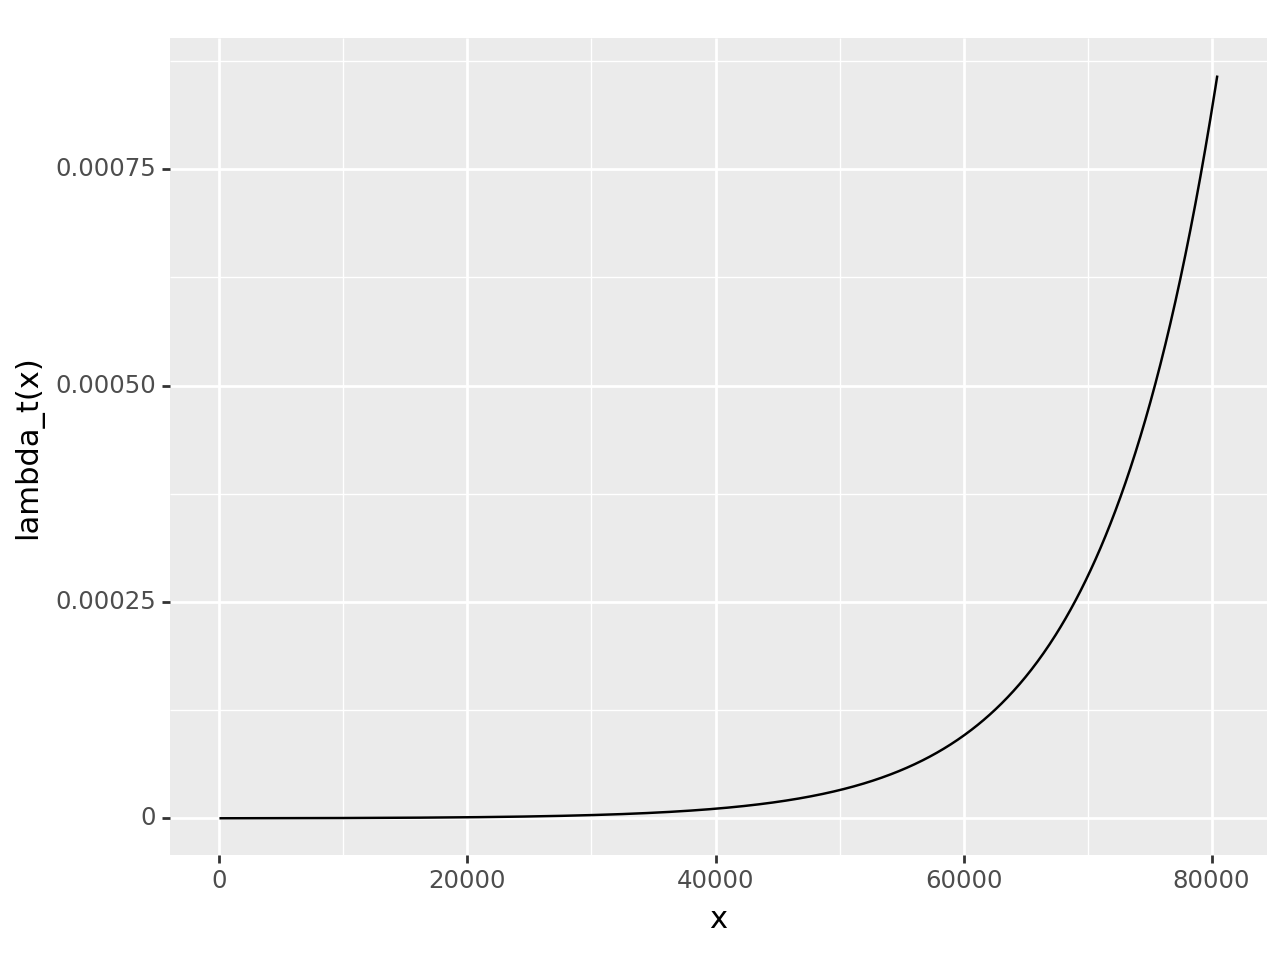

<Figure Size: (640 x 480)>

In [6]:
t = spioon_df[spioon_df['päev'] == 18]['sekund']
f = lambda theta: len(t) / theta + sum(t) - (len(t) * t.max()) / (1 - np.exp(-theta * t.max()))

theta_1 = scipy.optimize.fsolve(f, 0.001)
theta_0 = np.log(len(t)) + np.log(theta_1) - np.log(np.exp(theta_1 * t.max()) - 1)
lambda_t= lambda t: np.exp(theta_1 * t + theta_0)

x = np.linspace(0, t.max(), 1000)
ggplot() + geom_line(aes('x', 'lambda_t(x)'))

## Päevakaupa loendavad punktiprotsessid

In [7]:
g = ggplot(spioon_df) + theme_linedraw() + aes('sekund', 'päev')
g += labs(x='$t$', y='päev')
g += geom_vline(xintercept=reservaeg, color='r')
g += geom_point(shape='x')

# g.save('paber/spioonid_päevakaupa.png', dpi=100)
# g

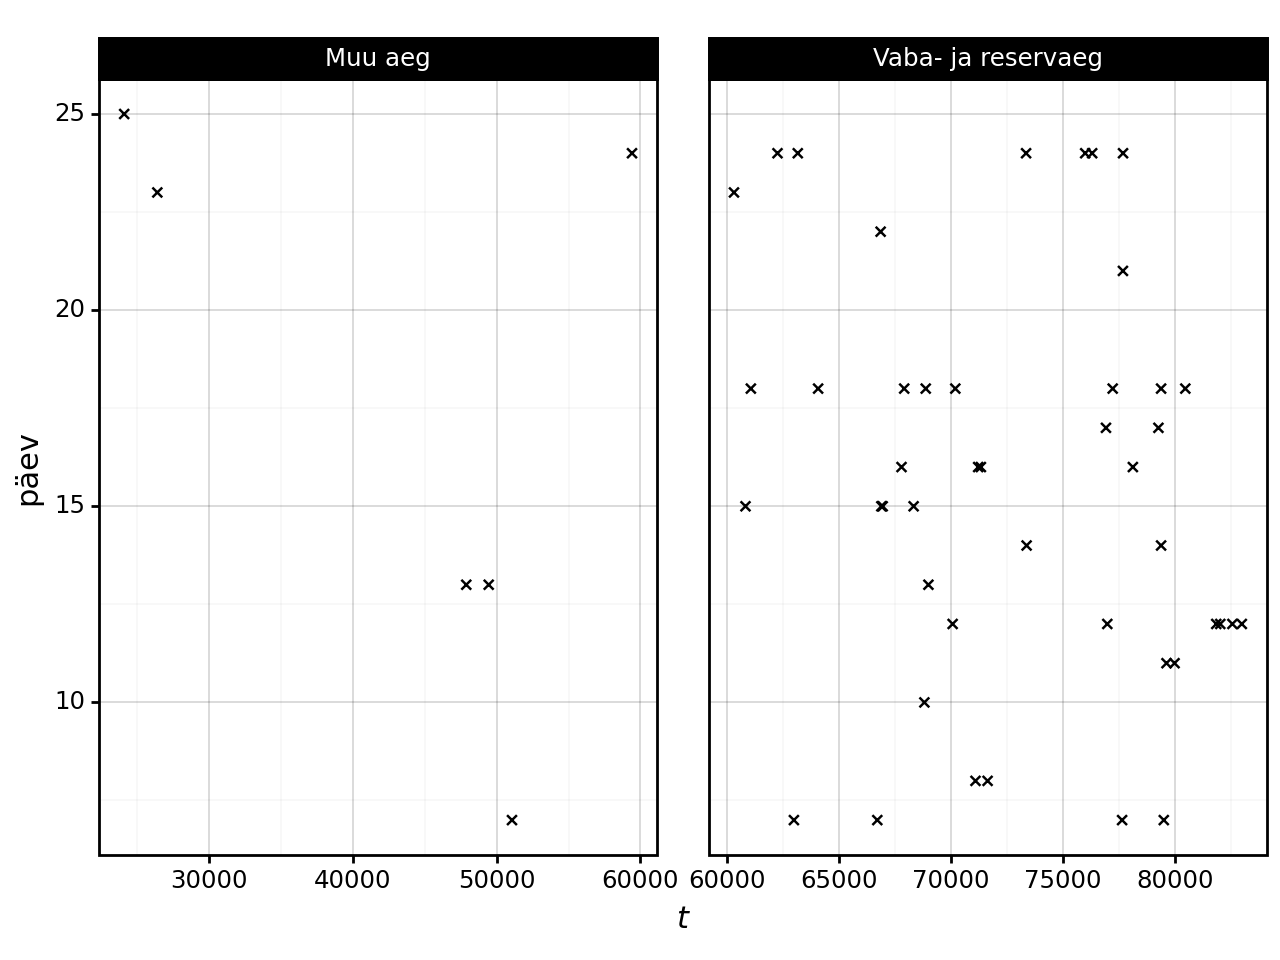

<Figure Size: (640 x 480)>

In [8]:
g = ggplot(spioon_df) + facet_wrap('tegevusaeg', scales='free_x') + aes('sekund', 'päev')
g += theme_linedraw() + theme(panel_spacing=0.04)
g += labs(x='$t$', y='päev')
g += geom_point(shape='x')

# g.save('paber/spioonid_päevakaupa_eraldatud.png', dpi=100)
g

## Astmejoonis

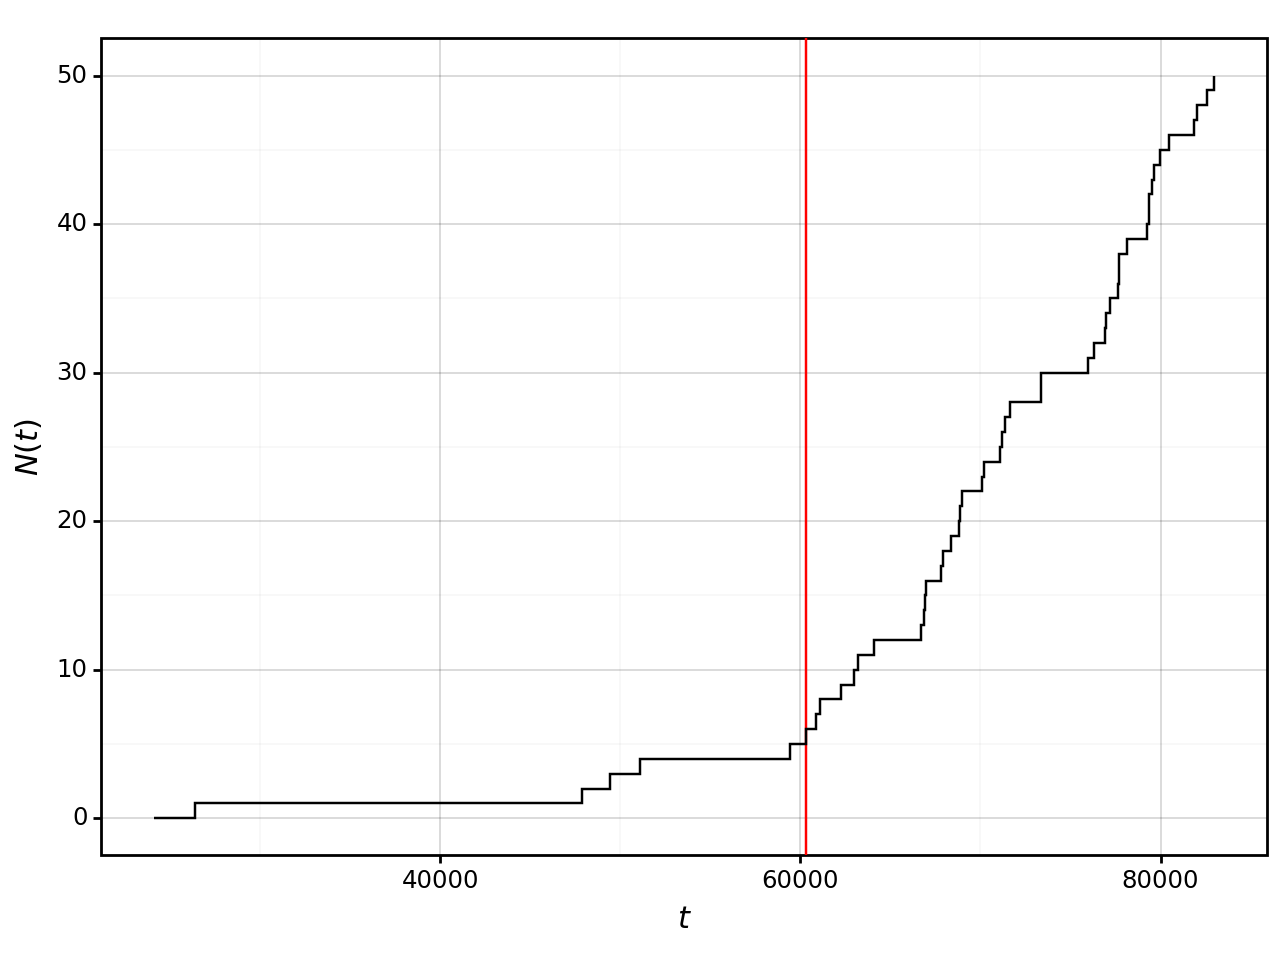

<Figure Size: (640 x 480)>

In [9]:
aste_df = spioon_df.sort_values('sekund')
aste_df['n'] = np.arange(0, aste_df.shape[0])

g = ggplot(aste_df) + theme_linedraw() + aes('sekund', 'n')
g += labs(x='$t$', y='$N(t)$')
g += geom_vline(xintercept=reservaeg, color='r')
g += geom_step()

# g.save('paber/spioonid_astmejoonis.png', dpi=100)
g